# Concept
Each feature of a file, say a GeoJSON file and determine which geohash grid cell completely contains it - we then create “buckets “or “folders” for each geohash it contains a file of those features contained within it. The parent-child relationships between the folders is just the hierarchy of the geohashes. You can go ahead and create a DAG and each folder/bucket that pertains to a geohash gets its own CID with each being based on all downstream children. At the top of the tree is a geohash that contains all of the features and the corresponding CID is the overall reference for the entire dataset.

# Prototype

In [59]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import random

## load some json files

### Generate random shapes (not in use)


### Load county layer of maryland

In [12]:
# URL to download the county shapefile for Maryland
shapefile_url = "https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip"

# Download and extract the shapefile
gdf = gpd.read_file(shapefile_url)

# Filter the data to keep only Maryland counties
maryland_gdf = gdf[gdf["STATEFP"] == "24"]

In [56]:
# Visualize the county map
maryland_gdf.to_crs("EPSG:4326").to_file('./md_county_plain.geojson')

In [15]:
maryland_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
130,24,047,01668802,24047,Worcester,Worcester County,06,H1,G4020,480,41540,NaN,A,1213156434,586531120,+38.2221332,-075.3099315,"POLYGON ((-75.54087 38.08948, -75.54126 38.089..."
169,24,001,01713506,24001,Allegany,Allegany County,06,H1,G4020,NaN,19060,NaN,A,1093502055,14761330,+39.6123134,-078.7031037,"POLYGON ((-78.95500 39.67630, -78.94681 39.690..."
183,24,510,01702381,24510,Baltimore,Baltimore city,25,C7,G4020,548,12580,NaN,F,209649327,28758743,+39.3000324,-076.6104761,"POLYGON ((-76.71151 39.36621, -76.71151 39.366..."
336,24,015,00596115,24015,Cecil,Cecil County,06,H1,G4020,428,37980,48864,A,896912528,185281258,+39.5623537,-075.9415852,"POLYGON ((-75.93711 39.72188, -75.93703 39.721..."
655,24,005,01695314,24005,Baltimore,Baltimore County,06,H1,G4020,548,12580,NaN,A,1549740654,215957832,+39.4431666,-076.6165693,"POLYGON ((-76.88730 39.44050, -76.88732 39.440..."


## Step-by-step pipeline

1. Get bounding box for each feature
2. geohash for each bounding box
3. pyramid features like a Trie
    - header for all features within this level of hash
    - buckets for next level
    

In [16]:
#1. get bounding box for each feature
bounding_boxes = maryland_gdf.bounds

In [21]:
#2.geohash for each bounding box

In [23]:
#!pip install pygeohash

In [17]:
import pygeohash as pgh
import os

In [18]:
pgh.encode(latitude=42.6, longitude=-5.6)

'ezs42e44yx96'

In [19]:
pgh.decode_exactly('d')

(22.5, -67.5, 22.5, 22.5)

In [66]:
def decode_helper(geohash):
    mid_lat,mid_lon,d_lat,d_lon = pgh.decode_exactly(geohash)

    min_longitude, max_longitude = mid_lon-d_lon, mid_lon+d_lon
    min_latitude, max_latitude = mid_lat-d_lat,mid_lat+d_lat

    polygon = Polygon([
            (min_longitude, min_latitude),
            (max_longitude, min_latitude),
            (max_longitude, max_latitude),
            (min_longitude, max_latitude),
            (min_longitude, min_latitude)
        ])
    #print(polygon)
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': [polygon],'geohash': [geohash]})
    return gdf

In [43]:
r = decode_helper('d')

POLYGON ((-90 0, -45 0, -45 45, -90 45, -90 0))


<Axes: >

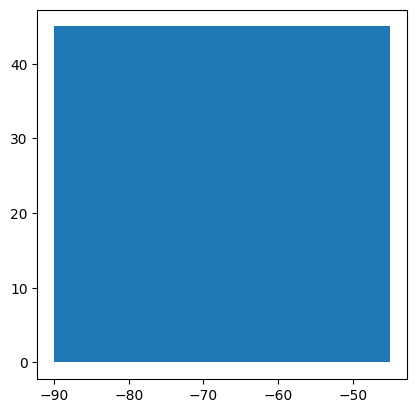

In [38]:
r.plot()

In [39]:
bounding_boxes

,minx,miny,maxx,maxy
130,-75.661827,37.994208,-74.986282,38.452034
169,-79.067559,39.438273,-78.313320,39.723037
183,-76.711519,39.197207,-76.529453,39.372206
336,-76.233279,39.360797,-75.766594,39.722207
655,-76.895596,39.156623,-76.287689,39.721302
816,-77.311562,39.348463,-76.787096,39.720802
874,-76.701960,38.305057,-76.321908,38.769281
908,-76.438814,38.058410,-75.701569,38.704185
1025,-76.840362,38.711099,-76.349479,39.237398
1050,-77.677164,39.220270,-77.106724,39.720045


In [40]:
# Apply geohash function to each pair of coordinates
bounding_boxes['minhash'] = bounding_boxes.apply(lambda row: pgh.encode(row['miny'], row['minx']), axis=1)
bounding_boxes['maxhash'] = bounding_boxes.apply(lambda row: pgh.encode(row['maxy'], row['maxx']), axis=1)

# Extract the left common substring from minhash and maxhash
bounding_boxes['common_hash'] = bounding_boxes.apply(lambda row: os.path.commonprefix([row['minhash'], row['maxhash']]), axis=1)

# Print the resulting DataFrame
bounding_boxes

,minx,miny,maxx,maxy,minhash,maxhash,common_hash
130,-75.661827,37.994208,-74.986282,38.452034,dqf0nk8sr9sw,dqfdtxuxkfxt,dqf
169,-79.067559,39.438273,-78.313320,39.723037,dppb2g8b86fy,dr03czmgrqu1,d
183,-76.711519,39.197207,-76.529453,39.372206,dqcqyrskk0cx,dqcxfx2zwrpv,dqc
336,-76.233279,39.360797,-75.766594,39.722207,dqczcm2t7b75,dr41gzhqwkhf,d
655,-76.895596,39.156623,-76.287689,39.721302,dqcqf0nrfexf,dr1cbp112525,d
816,-77.311562,39.348463,-76.787096,39.720802,dqcpbepmqj1h,dr13uwvq6ypm,d
874,-76.701960,38.305057,-76.321908,38.769281,dqc3yt5r4u1m,dqcsx38p6tu9,dqc
908,-76.438814,38.058410,-75.701569,38.704185,dqc8s86fq9c4,dqfhjmgu1x4b,dq
1025,-76.840362,38.711099,-76.349479,39.237398,dqck5rns3zck,dqcxnwun2jnh,dqc
1050,-77.677164,39.220270,-77.106724,39.720045,dqbz07v4wuhx,dr11vqud5153,d


In [ ]:
#3. given a list of index, value pairs, generate a trie dictionary to store the parent-child relation

In [34]:
#!pip install pygtrie

In [47]:
class TrieNode:
    def __init__(self):
        self.children = {}
        self.value = []


class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, index, value):
        node = self.root
        for char in str(index):
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.value.append(value)

    def get(self, index):
        node = self.root
        for char in str(index):
            if char not in node.children:
                return None
            node = node.children[char]
        return node.value

In [48]:
pairs = list(bounding_boxes['common_hash'].to_dict().items())


In [50]:
pairs = [(b,a) for a,b in pairs]

In [56]:
pairs

[('dqf', 130),
 ('d', 169),
 ('dqc', 183),
 ('d', 336),
 ('d', 655),
 ('d', 816),
 ('dqc', 874),
 ('dq', 908),
 ('dqc', 1025),
 ('d', 1050),
 ('dqc', 1361),
 ('dqc', 1392),
 ('d', 1439),
 ('dq', 1474),
 ('dq', 1480),
 ('dq', 1620),
 ('dq', 1729),
 ('dq', 1963),
 ('d', 1985),
 ('dq', 2003),
 ('d', 2064),
 ('dqc', 2488),
 ('d', 2742),
 ('dq', 2852)]

In [57]:
# Create an empty Trie dictionary
trie_dict = Trie()

# Insert each index-value pair into the Trie dictionary
for index, value in pairs:
    trie_dict.insert(index, value)

In [58]:
# Access the value associated with a particular index
index = 'd'
value = trie_dict.get(index)

In [63]:
trie_dict.root.children['d'].

In [52]:
# Print the Trie dictionary
print(trie_dict.root.children)

{'d': <__main__.TrieNode object at 0x10839ef10>}


In [64]:
trie_dict.root.value

[]

In [72]:
"/".join("dqc")

'd/q/c'

In [85]:
#export the Trie DAG to folder
def export_trie(trie_node,gdf,geohash,root_path):
    #export geojson at current hash level
    path = root_path+"/"+"/".join(geohash)
    json_path = root_path+"/"+"/".join(geohash[:-1])+f"/{geohash}.geojson"
    print(geohash,path,json_path)
    if trie_node.value:
        gdf.loc[trie_node.value].to_file(json_path,driver="GeoJSON")
    #make path and export to sub folder
    import os 
    if trie_node.children and not os.path.exists(path):
        os.makedirs(path)
    for ch in trie_node.children:
        child_hash = geohash+ch
        export_trie(trie_node.children[ch],gdf,child_hash,root_path)

In [86]:
export_trie(trie_dict.root,maryland_gdf,"","./export")

 ./export/ ./export//.geojson
d ./export/d ./export//d.geojson
dq ./export/d/q ./export/d/dq.geojson
dqf ./export/d/q/f ./export/d/q/dqf.geojson
dqc ./export/d/q/c ./export/d/q/dqc.geojson


In [ ]:
#visualizing 

In [67]:
def grid_level(head):
    base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    collections = []
    for nxt in base32:
        geohash = head+nxt
        shape = decode_helper(geohash)
        shape.crs = "EPSG:4326"
        collections.append(shape)
    grid = pd.concat(collections)
    grid.to_file(f'./geohash_grid/grid_level_{head}.geojson', driver='GeoJSON')

In [73]:
grid_level('dqcmc0')

In [53]:
# Example usage
geohash = 'dr'
shape = decode_helper(geohash)
shape.crs = "EPSG:4326"
# Save GeoDataFrame as GeoJSON
shape.to_file(f'./geohash_grid/hash_{geohash}.geojson', driver='GeoJSON')

POLYGON ((-78.75 39.375, -67.5 39.375, -67.5 45, -78.75 45, -78.75 39.375))


In [45]:
shape

,geometry
0,"POLYGON ((-90.00000 0.00000, -45.00000 0.00000..."


In [124]:
import os


def display_folder_structure(folder_path, indent=""):
    """Recursively displays the folder structure"""
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            print(indent + "+-- " + item)
            display_folder_structure(item_path, indent + "|   ")
        else:
            if item != ".DS_Store":
                print(indent + "|-- " + item)


# Example usage
folder_path = "./export/"
display_folder_structure(folder_path)


|-- d.geojson
+-- d
|   |-- dq.geojson
|   +-- q
|   |   |-- dqf.geojson
|   |   |-- dqc.geojson
